### Detection probability of a single planetary system

This notebook shows how to calculate the detection probabilities of a planetary system via Monte carlo simulations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import EPOS

initialize the EPOS class with the kepler dr25 exoplanets and survey completeness, updated with gaia dr2 stellar radii

In [2]:
epos= EPOS.epos(name='population', survey='Kepler')


 |~| epos 3.0.1.dev2 |~|

Initializing 'population'

Using random seed 3217594621

Survey: Kepler-Gaia all dwarfs, reliability > 0.9


Generate an example planetary system and loop it into EPOS

In [3]:
sma= np.geomspace(0.03,0.3,5) # au
radius= 10.**np.random.normal(0,0.2, sma.size) # Mearth
inc= np.random.rayleigh(0.3, sma.size) # degrees
starID= np.repeat('random system', sma.size)

epos.set_population('Planet Formation Model', sma=sma, radius=radius, inc=inc, starID=starID)
epos.modelpars.add('eta',10, isnorm=True)
epos.modelpars.add('f_iso',0)


  0 singles, 1 multis
  - single: 0
  - double: 0
  - triple: 0
  - quad: 0
  - quint: 1


In [4]:
EPOS.run.once(epos, Verbose=True)


Preparing EPOS run...
  Set f_cor to default 0.5
  Set f_inc to default 1.0
  Set f_dP to default 1.0

Starting the first MC run
  5 planets in 1 simulations
  122682 stars in survey, 1226820 draws, eta=10
  1226820/6134100 systems
  Average mutual inc=0.3 degrees

  6134100 planets, 462846 transit their star
  - single: 93907
  - double: 53110
  - triple: 29507
  - quad: 16657
  - quint: 21514
  462846 transiting planets, 311569 detectable
  - single: 95462
  - double: 89368
  - triple: 8444
  - quad: 2116
  - quint: 715

Goodness-of-fit
  logp= -inf
  - p(n=120558)=0
  - p(N_k)=0
  - p(P ratio)=2.3e-297
  - p(P inner)=1.6e-131
  - p(R ratio)=0
  observation comparison in 0.408 sec
Finished one MC in 4.436 sec


In [5]:
print (list(epos.population))

['order', 'P', 'Y', 'ID', 'k', 'inc', 'b', 'tdur', 'detectable', 'system', 'single', 'multi']


In [6]:
kth= np.unique(epos.population['k']+1)
nk= kth.size
kth

array([1, 2, 3, 4, 5])

Plot all possible combinations

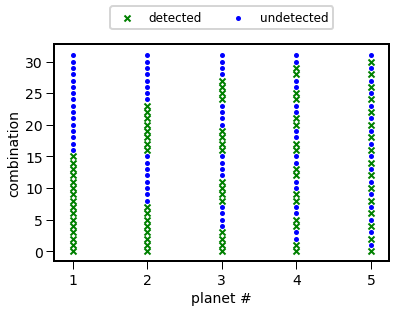

In [7]:
import itertools
combinations= list(itertools.product([True,False], repeat=nk))

for j, combo in enumerate(combinations):
    #plt.scatter(kth, [j]*len(combo), marker='.', c=combo) 
    # wrong color if all False?
    
    det_kj= kth[list(combo)]
    nondet_kj= kth[~np.array(combo)]

    plt.scatter(det_kj, [j]*len(det_kj), marker='x', c='g', 
                label='detected' if j==0 else '')
    plt.scatter(nondet_kj, [j]*len(nondet_kj), marker='.', c='b', 
                label='undetected' if j==0 else '')

plt.xlabel('planet #')
plt.ylabel('combination')
plt.legend(loc='upper center',bbox_to_anchor=(0.5,1.2), ncol=2)
plt.show()

For each combination, calculate the number of simulated detections

In [8]:
kth_is_detected= []
for k in kth:
    index_to_kth= (epos.population['k']+1)==k
    kth_is_detected.append(epos.population['detectable'][index_to_kth])
    #print (k, kth_is_detected[-1].sum())

n_combo_detected= []
for kdet in combinations:
    det_allk= []
    #print (kdet)
    for det, ktd in zip(kdet, kth_is_detected):
        det_allk.append(det == ktd)
        #print (det_allk[-1])
    x= np.all(det_allk, axis=0)
    #print (x.sum())
    n_combo_detected.append(x.sum())

And plot it

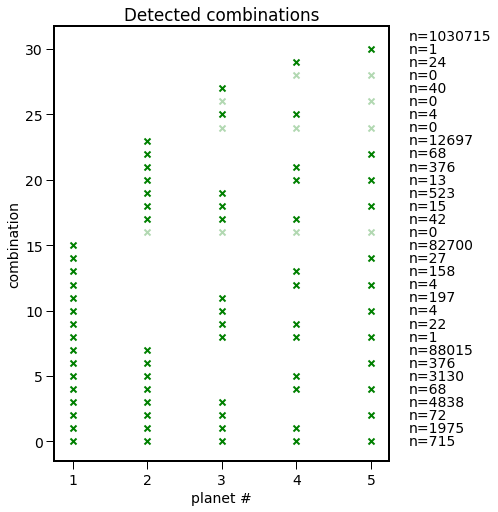

In [9]:
#plt.gcf().get_size_inches()
plt.figure(figsize=(6,8)) # default=(6,4)
for j, (ndet, combo) in enumerate(zip(n_combo_detected, combinations)):
    #plt.scatter(kth, [j]*len(combo), marker='.', c=combo) 
    # wrong color if all False?
    
    det_kj= kth[list(combo)]
    nondet_kj= kth[~np.array(combo)]

    alpha= 0.3 if ndet==0 else 1
    plt.scatter(det_kj, [j]*len(det_kj), marker='x', c='g', alpha=alpha)
    #plt.scatter(nondet_kj, [j]*len(nondet_kj), marker='.', c='b', alpha=alpha)
    plt.text(kth[-1]+0.5, j, 'n={}'.format(ndet), va='center' )

    plt.title('Detected combinations')
plt.xlabel('planet #')
plt.ylabel('combination')
#plt.legend(loc='upper center',bbox_to_anchor=(0.5,1.2), ncol=2)

plt.show()

Group together based on highest occurrence

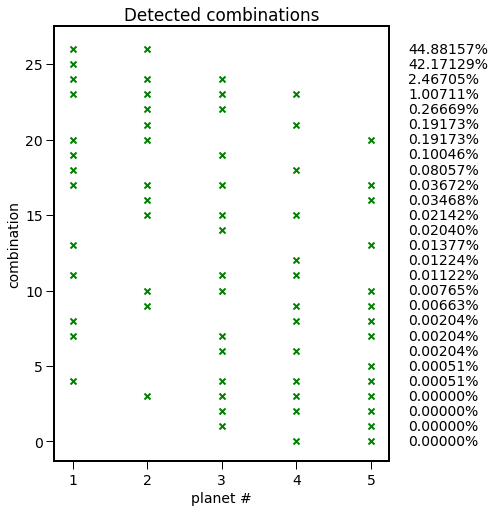

In [10]:
n_combo_detected= np.asarray(n_combo_detected)
combinations= np.asarray(combinations)

sorted_nonzero= np.argsort(n_combo_detected)[n_combo_detected>0]

n_nondetections= n_combo_detected[sorted_nonzero][-1]
eta= epos.modelpars.get('eta')
norm= 1/(eta*epos.nstars- n_nondetections)

plt.figure(figsize=(6,8))

for j, (ndet, combo) in enumerate(zip(n_combo_detected[sorted_nonzero][:-1], 
                                      combinations[sorted_nonzero][:-1])):
    
    det_kj= kth[list(combo)]

    plt.scatter(det_kj, [j]*len(det_kj), marker='x', c='g')
    plt.text(kth[-1]+0.5, j, '{:.5%}'.format(ndet*norm), 
             va='center' )

    plt.title('Detected combinations')
plt.xlabel('planet #')
plt.ylabel('combination')
#plt.legend(loc='upper center',bbox_to_anchor=(0.5,1.2), ncol=2)

plt.show()

Group together based on number of planets per system

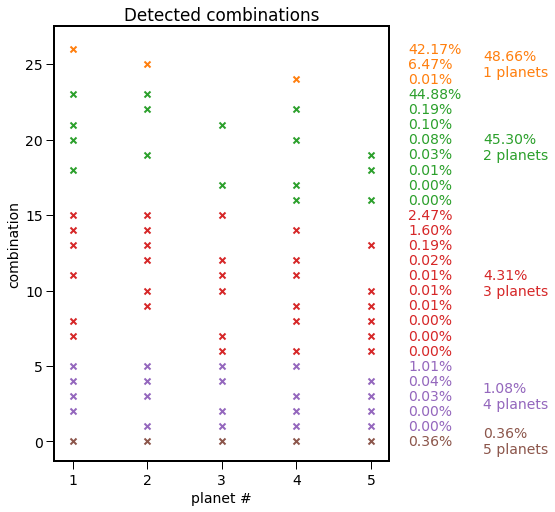

In [11]:
n_combo_detected= np.asarray(n_combo_detected)
combinations= np.asarray(combinations)

nplanets= np.sum(combinations, axis=1)
ix= np.lexsort( (n_combo_detected, -nplanets))[n_combo_detected>0][:-1]

plt.figure(figsize=(6,8))
plt.title('Detected combinations')

for j, (ndet, combo, npl) in enumerate(zip(n_combo_detected[ix], 
                                      combinations[ix],
                                      nplanets[ix])):    
    det_kj= kth[list(combo)]
    color='C{}'.format(npl)

    plt.scatter(det_kj, [j]*len(det_kj), marker='x', c=color)
    plt.text(kth[-1]+0.5, j, '{:.2%}'.format(ndet*norm), 
             va='center', color=color )

# add frequency of all systems with 1, 2, 3 etc. planets together
jrange= np.arange(nplanets[ix].size)
for npl in np.unique(nplanets[ix]):
    inp= (nplanets[ix]==npl)
    j_mid= np.mean(jrange[inp])
    freq_npl= np.sum(n_combo_detected[ix][inp])*norm
    color='C{}'.format(npl)
    plt.text(kth[-1]+1.5, j_mid, '{:.2%}\n{} planets'.format(freq_npl,npl), 
             va='center', color=color)

plt.xlabel('planet #')
plt.ylabel('combination')

plt.show()


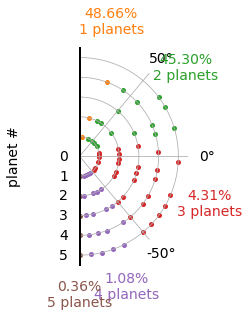

In [31]:
plt.polar()

for j, (ndet, combo, npl) in enumerate(zip(n_combo_detected[ix], 
                                      combinations[ix],
                                      nplanets[ix])):    
    th= np.pi*(j/ix.size) - np.pi/2
    det_kj= kth[list(combo)]
    color='C{}'.format(npl)

    plt.scatter([th]*len(det_kj), det_kj, marker='.', c=color)
    #plt.text(kth[-1]+0.5, th, '{:.2%}'.format(ndet*norm), 
    #         va='center', color=color )

# add frequency of all systems with 1, 2, 3 etc. planets together
jrange= np.arange(nplanets[ix].size)
for npl in np.unique(nplanets[ix]):
    inp= (nplanets[ix]==npl)
    j_mid= np.mean(jrange[inp])
    freq_npl= np.sum(n_combo_detected[ix][inp])*norm
    color='C{}'.format(npl)
    plt.text(np.pi*(j_mid/ix.size)- np.pi/2, kth[-1]+2,  '{:.2%}\n{} planets'.format(freq_npl,npl), 
             ha='center', va='center', color=color)    

ax=plt.gca()
ax.set_xlim(-np.pi/2,np.pi/2)
ax.set_ylim(0,kth[-1]+0.5)
ax.spines['polar'].set_visible(False)

plt.ylabel('planet #')
#plt.ylabel('combination')

plt.show()